# train wmn using additional generated images

In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
#root_dir = os.path.dirname(parent_dir)
sys.path.insert(0, parent_dir)

In [2]:
from evaluationModels.scut_wmn.FCSRN import fcsrn
from evaluationModels.scut_wmn import wmn_helpers
from evaluationModels import evalFunctions

from imageGenerators import load_realdata, distortions
from imageGenerators.imgGen_simple import synth_generator
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new

from models.cyclegan_modified.cyclegan import cyclegan

import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
from time import time
import re
import random
import pickle

import pprint
pp = pprint.PrettyPrinter(indent=4)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

In [4]:
# Path to i2i-model to use for imagegeneration and epoch to load
i2i_model = Path("D:/m2/savedmodels/goals/q1_n_images/n128_epochs16")
i2i_epoch = 11
# where to save model
fcsrn_model = Path("D:/m2/savedmodels/goals/eval2/pretrain/p4")
continue_training = True # whether to load and continue training of fcsrn
continue_epoch = 30



# parameters for building traindataset
#trainset = "generated"#trainset = "real" #trainset = "shuffle" 
trainset = "real"

digit_target = 0          # how many of each digit to generate
generate_fixed_amount = True # if True, generate <digit_target> of each digit; else generate digit until number of that digit in generated and real images combined is at least <digit_target>
train_epochs = 110     # how long to train with real difficult images
batchsize = 100
# Path to save fcsrn-model
#fcsrn_model = Path("D:/m2/savedmodels/goals/eval2/n128_epoch11/shuffle_dist")

# function applied to translated images
def distortionFuncton(image):
    distortions.brighten_blur(image, 60, 90, 0.6, 2, 0.025)
postprocess = distortionFuncton


postprocess = None
postprocess_name = "None" if postprocess is None else postprocess.__name__

In [5]:
N_DIGITS = 5   # digits per label
N_CLASSES = 20 # there are 10 digits and 10 midstate-digits

# dimensions of input to wmn-model
fcsrn_height = 48; fcsrn_width = 160; fcsrn_channels = 1
fcsrn_shape = (fcsrn_height, fcsrn_width, fcsrn_channels)
fcsrn_dims = (fcsrn_width, fcsrn_height)
# get shape of inputs for i2i-model
inputshapePath = i2i_model / "inputshape"
i2i_shape = [int(s) for s in inputshapePath.read_text().split(",")]
i2i_dims = (i2i_shape[1], i2i_shape[0])



In [6]:
def showImage(image):
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image[:,:,0]
    image = image.astype(int)
    plt.imshow(image, cmap="gray", vmin=0, vmax=255)
    plt.show()
def showImages(images, n, labels=None):
    for i in range(min(n, len(images))):
        if not labels is None:
            print(labels[i])
        image = images[i]
        showImage(image)

In [7]:
# save parameter-variable names and values
def save_parameters():
    params = [
        "trainset",
        "digit_target",
        "generate_fixed_amount",
        "train_epochs",
        
        "batchsize",
        "i2i_model",
        "continue_training",
        "continue_epoch",
        "fcsrn_model",
        "postprocess_name",
        
        
    ]
    txt = ""
    for param in params:
        txt += "%s\t= %s\n" % (param, eval(param))
        
    filepath = fcsrn_model / "parameters.txt"
    filepath.touch()
    filepath.write_text(txt)
    
def to3channel(images):
    shape = images.shape
    if len(shape) < 4:
        shape = [d for d in shape]
        shape.append(1)
        images = np.reshape(images, shape)
        images = np.repeat(images, 3, axis=-1)
        print(images.shape)
    return images
def to1channel(images):
    shape = images.shape
    if len(shape) < 4:
        shape = [d for d in shape]
        shape.append(1)
        images = np.reshape(images, shape)
        print(images.shape)
    return images

# Generate Images

In [8]:
####
# return map from digits(0-20) to number of each digit to generate
####
def n_digitsToGenerate():
    # map digits(0-20) to number to generate of each digit
    digitCount_map = {}
    if generate_fixed_amount:
        # generate same number of each digit
        for digit in range(20):
            digitCount_map[digit] = digit_target
    else:
        ###
        # generate each digit so that number of each digit in real+generated images adds up to target
        ### 
        #count how often each digit occurs in real images
        digits, counts = np.unique(labels_train.flatten(), return_counts=True)
        for digit in range(20):
            digitCount_map[digit] = target - counts[digit] if counts[digit] < targetDigitCount else 0
    return digitCount_map

####
# taking a map of digit-digitcount, 
# returns array of labels.
####
def targetCount_to_labels(n_toGenerate):
    # number of additional digits
    sum_additionalDigits = sum(n_toGenerate.values())
    # number of additional images
    n_additionalImages = int(sum_additionalDigits / N_DIGITS)
    # make flat ordered list containing each digit to generate
    labels_gen = np.concatenate([
        np.full(shape=count, fill_value=digit) for digit, count in n_toGenerate.items()
    ])
    # shuffle that list, then reshape to list of labels
    np.random.shuffle(labels_gen)
    labels_gen = np.reshape(labels_gen, (n_additionalImages, N_DIGITS) )
    return labels_gen

####
# taking a list of labels, generate an image for each label (using new generator)
####
def generate_synthethic_newGenerator(labels, show_generated=5):
    synthGenerator = synth_generator_new()
    images = synthGenerator.makeImages(labels, resizeTo=i2i_dims, color=True, rotate=True)
    print("synthetic images:")
    showImages(images, show_generated, labels)
    return images

In [9]:
# translate synthetic images into realistic images using cyclegan
def translate_images(synthImages, keepRatio = True, show_generated=5, postprocess=None):
    ####
    # load i2i model - most parameters dont matter when not training
    cgModel = cyclegan(i2i_shape,-1,-1, "mse", checkpoint_path=i2i_model, load_checkpoint_after_epoch=i2i_epoch)
    # prepare input for cgan
    cgan_input = tf.data.Dataset.from_tensor_slices(synthImages)\
                .map(cgModel.preprocess_input, num_parallel_calls=AUTOTUNE)\
                .cache()\
                .batch(1)
    ####
    # predict realistic images
    translated_images = cgModel.gen_AtoB.predict(cgan_input)
    
    # denormalize
    translated_images = (translated_images + 1) * 127.5
    if not postprocess is None:
        translated_images = translated_images[:,:,:,0]
        for image in translated_images2:
            postprocess(image) 
    
    # resize to inputshape of wmn-model
    if keepRatio:
        translated_images = np.array([
            wmn_helpers.resize_withPadding(image, fcsrn_width, fcsrn_height) for image in translated_images
        ])
    else:       
        translated_images = np.array([
            cv2.resize(image, fcsrn_dims) for image in translated_images
        ])
        
                
        
    print("translated images:")
    showImages(translated_images, show_generated)    
    return translated_images

In [10]:
def pipeline_generateImages(show_images=5):
    digitCount_map = n_digitsToGenerate()
    labels_synth = targetCount_to_labels(digitCount_map)
    images_synth = generate_synthethic_newGenerator(labels_synth, show_images)
    images_translated = translate_images(images_synth, keepRatio=True, show_generated=show_images, postprocess=postprocess)
    return images_translated, labels_synth

In [11]:
def make_dataset(list):
    return tf.data.Dataset.from_tensor_slices(list)\
        .cache() \
        .batch(batchsize, drop_remainder=False)

# prepare tf.dataset of trainingdata. dataset must be either "generated", "real", "shuffle"
def pipeline_makeTrainDatasets(trainset):    
    
    if trainset == "generated":
        images_translated, labels_synth = pipeline_generateImages(show_images=5)
        images_translated = to1channel(images_translated).astype("float32")
        
        image_ds = make_dataset(images_translated)
        labels_ds = make_dataset(labels_synth)
        
    elif trainset == "real":
        images_real, labels_real = load_realdata.load_wmr_diff_train(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        #images_real = to3channel(images_real).astype("float32")
        images_real = to1channel(images_real).astype("float32")
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
        
    elif trainset == "shuffle":
        # append generated data to real data and shuffle result
        images_translated, labels_synth = pipeline_generateImages(show_images=5)
        images_translated = to1channel(images_translated).astype("float32")
        images_real, labels_real = load_realdata.load_wmr_diff_train(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        images_real = to3channel(images_real).astype("float32")
        
        images_real = np.append(images_real, images_translated, axis=0)
        labels_real = np.append(labels_real, labels_synth, axis=0)
        zip_real = list(zip(images_real, labels_real))
        random.shuffle(zip_real)    
        images_real, labels_real = zip(*zip_real)
        images_real = np.array(images_real)
        labels_real = np.array(labels_real)
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
    elif trainset == "easy":
        images_real, labels_real = load_realdata.load_wmr_easy(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True, processImage=None)
        images_real = to1channel(images_real).astype("float32")
        
        image_ds = make_dataset(images_real)
        labels_ds = make_dataset(labels_real)
    else:
        raise Exception("unknown trainset: %s" % (trainset) )
            
    
    return (image_ds, labels_ds)

In [12]:
# make traindatasets
stime = time()
image_ds, labels_ds = pipeline_makeTrainDatasets(trainset)
print("pipeline took %.2f seconds" % (time() - stime) )


# load testdata
images_test, labels_test = load_realdata.load_wmr_diff_test(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True)
images_test = to1channel(images_test).astype("float32")

C:\Users\andre\jupyter_ws\imageGenerators\load_realdata.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


(4000, 48, 160, 1)
pipeline took 3.62 seconds
(1000, 48, 160, 1)


In [13]:

if continue_training:
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=continue_epoch)
    fcsrn_model = fcsrn_model/ ( "next_after_%d" % (continue_epoch) )
    assert not fcsrn_model.exists(), ( "cant continue training. path already exists: %s" %( str(fcsrn_model) ) )
    fcsrn_model.mkdir()
    model.set_checkpointDir(fcsrn_model)
else:
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=None)
    

save_parameters()    
print("training for %d epochs" % (train_epochs) )
model.train(image_ds, labels_ds, train_epochs, batchsize, images_test, labels_test, checkpointInterval=1)
images_test = to3channel(images_test).astype("float32")

loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\epoch-30
training for 110 epochs
40/40 [==============================] - 46s 1s/step
epoch 1 took: 45.64 seconds
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
ar(epoch=1)=0.186400	4.004181seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-1
40/40 [==============================] - 39s 969ms/step
epoch 2 took: 38.76 seconds
ar(epoch=2)=0.073200	1.135937seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-2
40/40 [==============================] - 39s 965ms/step
epoch 3 took: 38.63 seconds
ar(epoch=3)=0.222000	1.139953seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-3
40/40 [==============================] - 39s 969ms/step
epoch 4 took: 38.78 seconds
ar(epoch=4)=0.587400	1.136976seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-4
40/40 [======================

ar(epoch=40)=0.874400	1.147838seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-40
40/40 [==============================] - 39s 983ms/step
epoch 41 took: 39.33 seconds
ar(epoch=41)=0.901000	1.142936seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-41
40/40 [==============================] - 39s 966ms/step
epoch 42 took: 38.66 seconds
ar(epoch=42)=0.900400	1.143938seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-42
40/40 [==============================] - 39s 969ms/step
epoch 43 took: 38.79 seconds
ar(epoch=43)=0.919000	1.143942seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-43
40/40 [==============================] - 39s 968ms/step
epoch 44 took: 38.73 seconds
ar(epoch=44)=0.921800	1.145937seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-44
40/40 [==============================] - 40s 994ms/step
epoch 45 took: 39.76 seconds
ar(epoch=4

40/40 [==============================] - 39s 971ms/step
epoch 82 took: 38.84 seconds
ar(epoch=82)=0.964800	1.141958seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-82
40/40 [==============================] - 39s 973ms/step
epoch 83 took: 38.93 seconds
ar(epoch=83)=0.964600	1.139952seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-83
40/40 [==============================] - 39s 985ms/step
epoch 84 took: 39.44 seconds
ar(epoch=84)=0.964600	1.141948seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-84
40/40 [==============================] - 40s 995ms/step
epoch 85 took: 39.82 seconds
ar(epoch=85)=0.964200	1.145952seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-85
40/40 [==============================] - 40s 990ms/step
epoch 86 took: 39.63 seconds
ar(epoch=86)=0.964000	1.145937seconds
saved to: D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-86
40/40 [===

In [14]:
#------

synthetic images:
[12  2  3 19  5]


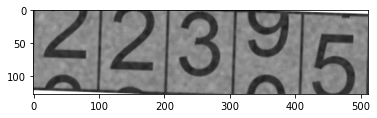

[ 7  8  1  6 12]


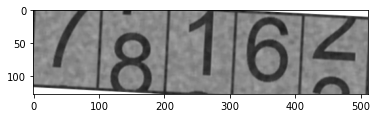

[12 14  5  5  2]


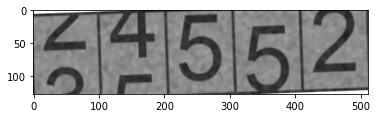

[10  0 10 14 18]


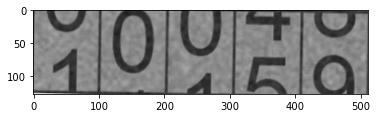

[17  8 10 19 12]


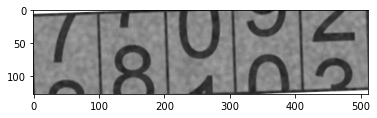

loaded checkpoint:  D:\m2\savedmodels\goals\q1_n_images\n128_epochs16\epoch-11
translated images:
(1000, 48, 160, 1)
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-1
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-2
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-3
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-4
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-5
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-6
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-7
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-8


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-9
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-10
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-11
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-12
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-13
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-14
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-15
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-16
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-17
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-18


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-19
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-20
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-21
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-22
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-23
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-24
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-25
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-26
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-27
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-28


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-29
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-30
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-31
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-32
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-33
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-34
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-35
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-36
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-37
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-38


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-39
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-40
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-41
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-42
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-43
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-44
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-45
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-46
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-47
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-48


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-49
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-50
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-51
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-52
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-53
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-54
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-55
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-56
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-57
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-58


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-59
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-60
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-61
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-62
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-63
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-64
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-65
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-66
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-67
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-68


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-69
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-70
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-71
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-72
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-73
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-74
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-75
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-76
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-77
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-78


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-79
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-80
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-81
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-82
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-83
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-84
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-85
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-86
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-87
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-88


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-89
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-90
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-91
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-92
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-93
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-94
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-95
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-96
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-97
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-98


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-99
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-100
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-101
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-102
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-103
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-104
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-105
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-106
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-107
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-108


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-109
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-110
AR(gen)
1,0.069200
2,-0.129400
3,-0.133800
4,0.129400
5,0.245000
6,0.291600
7,0.287200
8,0.260400
9,0.264800
10,0.291200
11,0.285200
12,0.306000
13,0.313000
14,0.356000
15,0.361200
16,0.362000
17,0.358800
18,0.337200
19,0.264400
20,0.313000
21,0.331600
22,0.384400
23,0.382600
24,0.388200
25,0.410800
26,0.348800
27,0.332600
28,0.292400
29,0.339000
30,0.319000
31,0.282800
32,0.343400
33,0.326000
34,0.303200
35,0.357000
36,0.320200
37,0.334200
38,0.347400
39,0.351600
40,0.334200
41,0.337200
42,0.346800
43,0.346000
44,0.403600
45,0.296400
46,0.390400
47,0.355400
48,0.333200
49,0.315200
50,0.344800
51,0.357800
52,0.418400
53,0.367800
54,0.355400
55,0.302200
56,0.347600
57,0.350600
58,0.374600
59,0.396400
60,0.383000
61,0.390000
62,0.371600
63,0.422600
64,0.413200
65,0.402000
66,0.429400
67,0.426400
68,0.414400
69,0.401400

In [15]:
# ar to gen images

del model
labels_test = np.random.randint(0,20,(1000,5))
synthImages = generate_synthethic_newGenerator(labels_test, show_generated=5)
images_test = translate_images(synthImages, keepRatio = True, show_generated=0)
images_test = to1channel(images_test).astype("float32")

txt = ""
for i in range(1,train_epochs+1):
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=i)
    ar = model.character_accuracyRate(images_test, labels_test)
    ar_str = ("%d,%f\n" % (i,ar))
    txt += ar_str
    #print(ar_str)
print("AR(gen)")
print(txt)

In [16]:
# ar to easy images

del model
images_test, labels_test = load_realdata.load_wmr_easy(n_toLoad = None, resizeTo=fcsrn_dims, keepRatio=True)
images_test = to1channel(images_test).astype("float32")
txt = ""
for i in range(1,train_epochs+1):
    model = fcsrn(fcsrn_shape, checkpoint_path=fcsrn_model, epoch_to_load=i)
    ar = model.character_accuracyRate(images_test, labels_test)
    ar_str = ("%d,%f\n" % (i,ar))
    txt += ar_str
    #print(ar_str)
print("AR(easy)")
print(txt)

C:\Users\andre\jupyter_ws\imageGenerators\load_realdata.py:57: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


(1000, 48, 160, 1)
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-1
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-2
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-3
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-4
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-5
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-6
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-7
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-8
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-9
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-10
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-11


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-12
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-13
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-14
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-15
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-16
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-17
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-18
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-19
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-20
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-21


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-22
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-23
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-24
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-25
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-26
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-27
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-28
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-29
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-30
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-31


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-32
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-33
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-34
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-35
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-36
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-37
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-38
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-39
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-40
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-41


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-42
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-43
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-44
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-45
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-46
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-47
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-48
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-49
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-50
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-51


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-52
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-53
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-54
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-55
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-56
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-57
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-58
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-59
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-60
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-61


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-62
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-63
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-64
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-65
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-66
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-67
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-68
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-69
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-70
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-71


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-72
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-73
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-74
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-75
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-76
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-77
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-78
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-79
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-80
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-81


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-82
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-83
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-84
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-85
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-86
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-87
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-88
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-89
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-90
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-91


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-92
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-93
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-94
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-95
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-96
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-97
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-98
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-99
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-100
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-101


loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-102
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-103
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-104
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-105
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-106
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-107
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-108
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-109
loaded checkpoint:  D:\m2\savedmodels\goals\eval2\pretrain\p4\next_after_30\epoch-110
AR(easy)
1,0.117000
2,0.068800
3,-0.002000
4,0.211000
5,0.408000
6,0.471000
7,0.475200
8,0.436600
9,0.451400
10,0.460000
11,0.462400
12,0.465000
13,0.454000
14,0.507800
15,0.499000
16,0.552400
17,0.560600
18,0.503200
19,0.4016